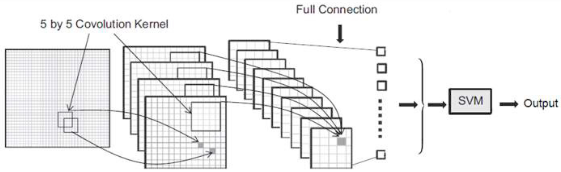

# Classification foliar diseases in apple trees

## Import Packages

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os

ImportError: cannot import name 'Precision' from 'keras.metrics' (unknown location)

## Preprocessing Dataset Images

In [7]:
dataset_folder = os.path.join("plant-pathology-2020-fgvc7")

In [8]:
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [9]:
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))
# create a list of file paths that point to all files in the "images" directory with any extension

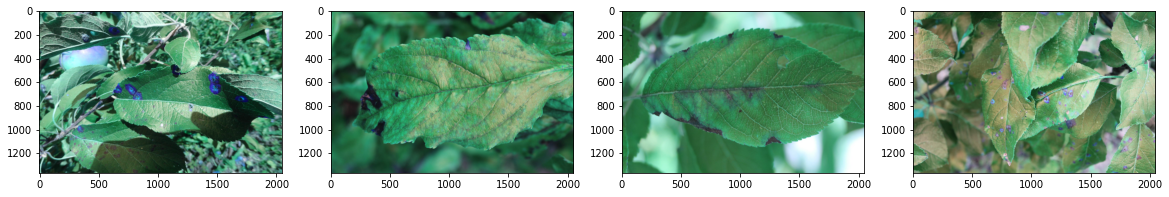

In [10]:
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()

In [11]:
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']

In [12]:
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)

In [55]:
images.shape

(16389, 100, 100, 3)

/Users/dheerajyadav/opt/anaconda3/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


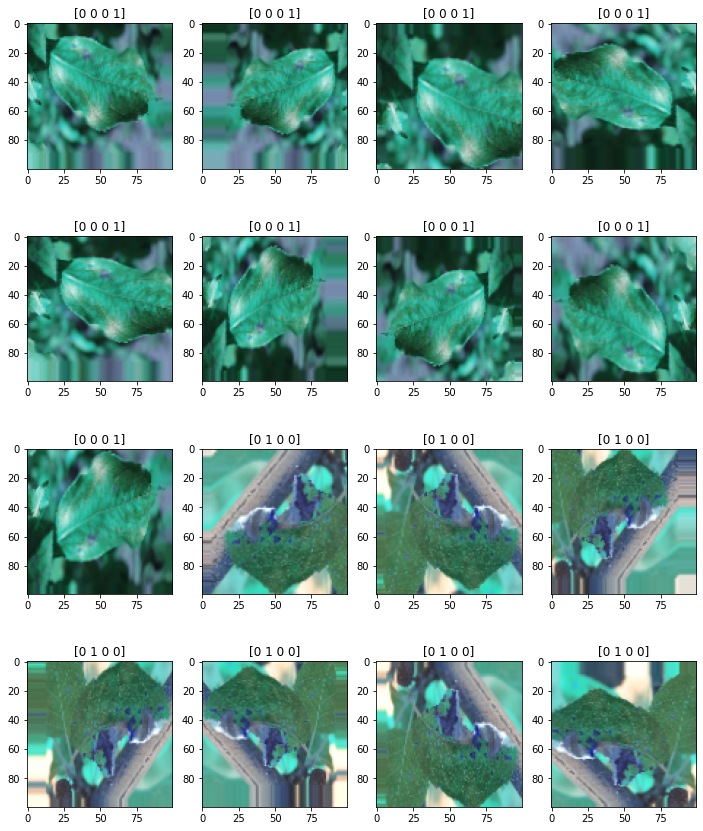

In [54]:
plt.figure(figsize = (12, 15))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()
# 4x4 grid of subplots, each containing an image from the images list and its associated label as the title

In [14]:
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)
# data augmentation techniques help to increase the diversity of the training data and improve the robustness of the machine learning model to variations in the input images.

## Images Data Augentation

In [15]:
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(9):
#     reshape image to 4D as required by img_data_g.flow() object then next function applies a random augmentation to the image
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
#     reshape the image back to 3D and push all the new labels of augmented images nine times to labels_after_aug
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)
# outer for loop iterates over the original images inner for loop applies the data augmentation to each image nine times

In [16]:
images.shape

(16389, 100, 100, 3)

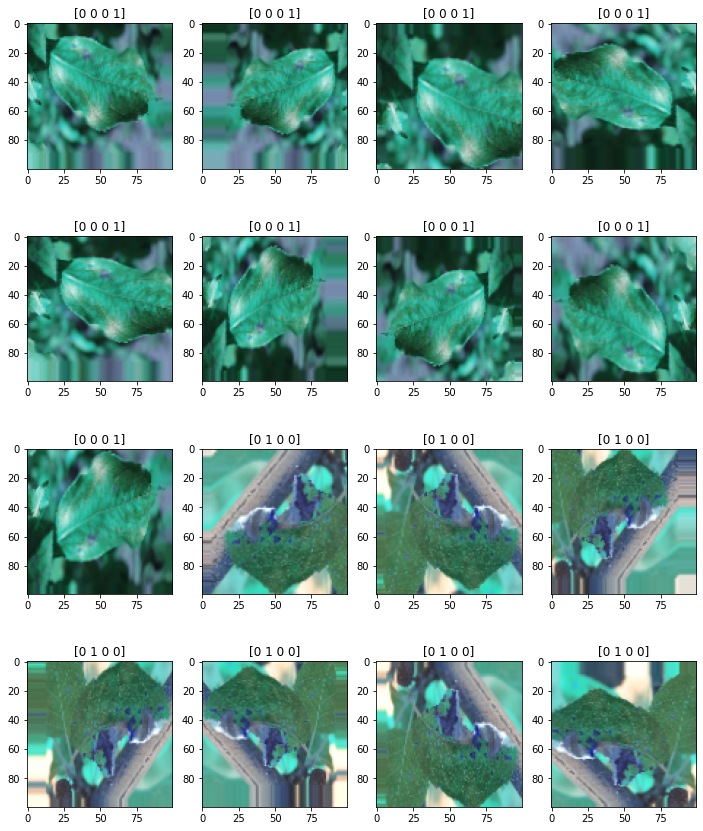

In [18]:
plt.figure(figsize = (12, 15))
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()

## Build Model

In [19]:
d = tf.keras.applications.DenseNet121(include_top=False,#exclude the top layer so that the model can be fine-tuned for new task
                   input_shape=(100,100,3),
                   pooling=None,#no pooling
                   weights='imagenet') # use the pre-trained weights
for i in d.layers:
#     set the layer i to be trainable
  i.trainable = True

Metal device set to: Apple M1
29084464/29084464 [==============================] - 6s 0us/step


In [20]:
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
# applies global average pooling to the output of the pre-trained model, which reduces the spatial dimensions of the output to 1x1, resulting in a 2D tensor of shape (batch_size, channels)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max]) #takes the element-wise minimum of the output tensors from the previous two layers
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
# dropout layer with drop factor of 0.3 to prevent overfitting
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(512, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)#define the input and output tensors
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), #apply adam optimizer
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 25, 25, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 25, 25, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 25, 25, 32)   36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 25, 25, 192)  0          ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 12, 12, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 12, 12, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 12, 12, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 12, 12, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 12, 12, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 12, 12, 320)  1280       ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 12, 12, 320)  0          ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 12, 12, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 12, 12, 128)  57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 12, 12, 128)  512        ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 6, 6, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 6, 6, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 6, 6, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 6, 6, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 6, 6, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 6, 6, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 6, 6, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 6, 6, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 6, 6, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 6, 6, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 6, 6, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 6, 6, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 6, 6, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 6, 6, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 6, 6, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 6, 6, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 6, 6, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 6, 6, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 6, 6, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 6, 6, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 3, 3, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 3, 3, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 3, 3, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 3, 3, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 3, 3, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 3, 3, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 3, 3, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 3, 3, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 3, 3, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 3, 3, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 3, 3, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 3, 3, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

 dropout_1 (Dropout)            (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 256)          33024       ['dropout_1[0][0]']              
                                                                                                  
 dropout_2 (Dropout)            (None, 256)          0           ['dense_1[0][0]']                
                                                                                                  
 dense_2 (Dense)                (None, 512)          131584      ['dropout_2[0][0]']              
                                                                                                  
 dropout_3 (Dropout)            (None, 512)          0           ['dense_2[0][0]']                
                                                                                                  
 dense_3 (

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)

In [22]:
x_train.shape

(13930, 100, 100, 3)

In [23]:
x_test.shape

(2459, 100, 100, 3)

## Train Model

In [24]:
history = m.fit(x_train, y_train, epochs = 30, batch_size = 32,
                callbacks = [
                    #This callback reduces the learning rate of the optimizer if the validation loss does not improve for a certain number of epochs 
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    #This callback stops the training process if the validation loss does not improve for a certain number of epochs.
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])

Epoch 1/30


2023-04-02 17:40:50.480870: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


436/436 [==============================] - 231s 471ms/step - loss: 0.5789 - accuracy: 0.8000 - precision: 0.8556 - recall: 0.7487 - lr: 0.0010
Epoch 2/30
436/436 [==============================] - 192s 440ms/step - loss: 0.3344 - accuracy: 0.8971 - precision: 0.9162 - recall: 0.8793 - lr: 0.0010
Epoch 3/30
436/436 [==============================] - 265s 608ms/step - loss: 0.2639 - accuracy: 0.9159 - precision: 0.9320 - recall: 0.9009 - lr: 0.0010
Epoch 4/30
436/436 [==============================] - 198s 453ms/step - loss: 0.2374 - accuracy: 0.9240 - precision: 0.9386 - recall: 0.9116 - lr: 0.0010
Epoch 5/30
436/436 [==============================] - 208s 477ms/step - loss: 0.1915 - accuracy: 0.9373 - precision: 0.9470 - recall: 0.9283 - lr: 0.0010
Epoch 6/30
436/436 [==============================] - 252s 577ms/step - loss: 0.1726 - accuracy: 0.9433 - precision: 0.9522 - recall: 0.9357 - lr: 0.0010
Epoch 7/30
436/436 [==============================] - 198s 454ms/step - loss: 0.1564 - 

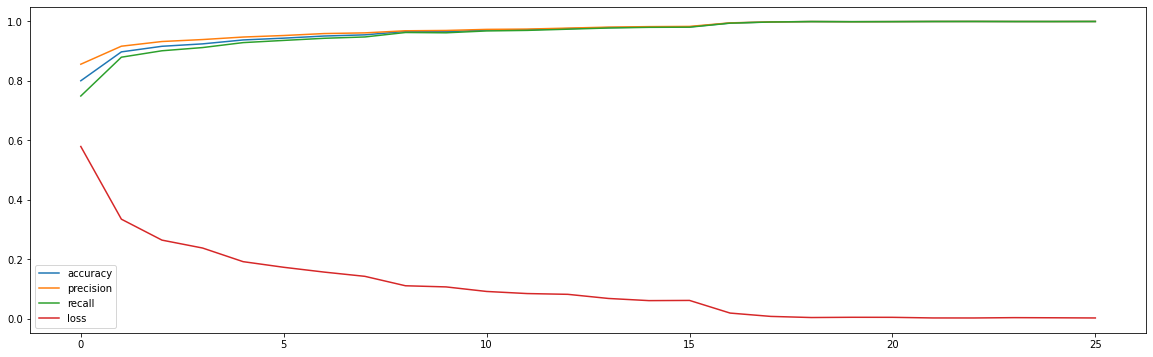

In [25]:
plt.figure(figsize = (20, 6))
# plots all the parameters of training history wrt each epoch 
# precision measures how near the calculated results are to one another, whereas accuracy deals with how close they are to the actual value of the measurement.
plt.plot(history.history['accuracy'], label = "accuracy")
plt.plot(history.history['precision'], label = "precision")
plt.plot(history.history['recall'], label = "recall")
plt.plot(history.history['loss'], label = "loss")
plt.legend()

In [26]:
m.evaluate(x_test, y_test, batch_size= 32)
# loss,accuracy,precision,recall

77/77 [==============================] - 22s 203ms/step - loss: 0.0522 - accuracy: 0.9858 - precision: 0.9858 - recall: 0.9850


[0.05216432735323906,
 0.985766589641571,
 0.9857550263404846,
 0.9849532842636108]

In [27]:
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
# y_pred contains the predicted class label for each imgage on test set
#The predicted class for each image is the class with the highest probability score among the four possible classes (healthy, multiple diseases, rust, scab)

77/77 [==============================] - 16s 156ms/step


In [28]:
y_pred

array([3, 3, 2, ..., 2, 0, 0])

In [29]:
y_test = np.argmax(y_test, axis = 1)

In [30]:
cnn_standard_acc = accuracy_score(y_pred, y_test)
print(cnn_standard_acc)
# cnn_standard_acc contains the accuracy score of the model on the test set, which is the proportion of correctly classified images out of all the test images.

0.9857665717771452


In [31]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       730
           1       0.81      0.95      0.87        93
           2       1.00      1.00      1.00       832
           3       0.99      0.98      0.99       804

    accuracy                           0.99      2459
   macro avg       0.95      0.98      0.96      2459
weighted avg       0.99      0.99      0.99      2459



In [32]:
def generate_confusion_matrix(y_pred, y_test):
    c = tf.math.confusion_matrix(y_pred, y_test)
    sns.heatmap(c, annot=True)

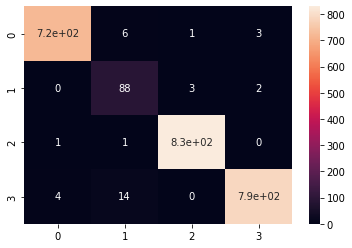

In [33]:
generate_confusion_matrix(y_pred, y_test)
# plot the confusion matrix as heatmap
# diaogonal elements shows the number of correctly classified elements of each class

# CNN Features + (RandomForest , XGBOOST, SVM)

## Extract CNN features from CMM pre_traind Model

In [34]:
new_model = tf.keras.models.Model(
    m.input, m.get_layer('minimum').output
)

In [35]:
features_x_train = new_model.predict(x_train)

436/436 [==============================] - 63s 133ms/step


In [36]:
features_x_test = new_model.predict(x_test)

77/77 [==============================] - 13s 157ms/step


In [37]:
features_x_train.shape

(13930, 1024)

## Features Engineering by scaling it

In [38]:
scaler = StandardScaler()
scaler.fit(features_x_train)

StandardScaler()

In [39]:
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)

## XGBClassifier

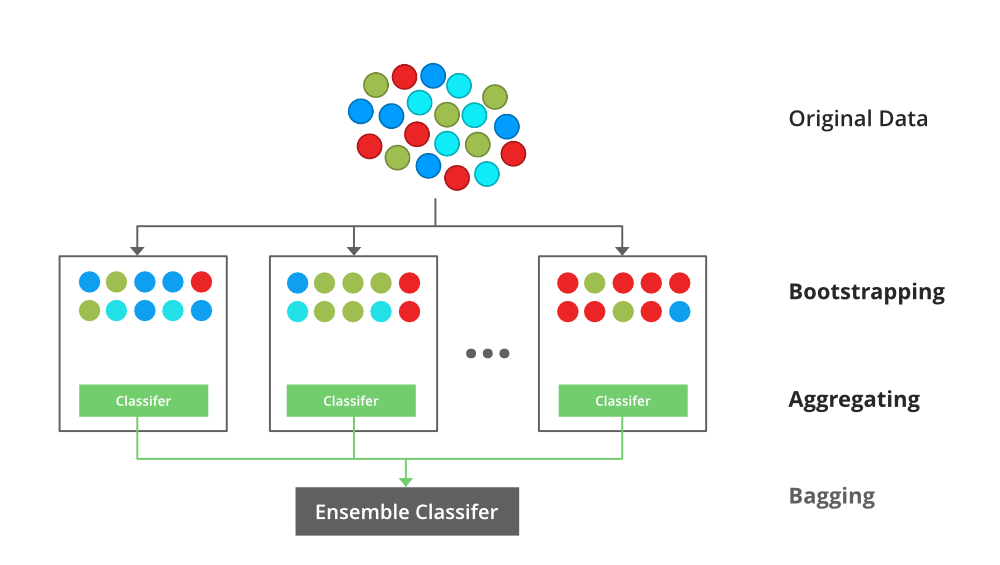

In [40]:
clf = xgb.XGBClassifier(max_depth = 50, n_estimators = 500)# maximum depth of the tree and n_estimators is the maximum number of tree in the forest
clf.fit(x_tr, np.argmax(y_train, axis = 1))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [41]:
y_pred = clf.predict(x_te)

In [42]:
xgboost_acc = accuracy_score(y_pred, y_test)
print(xgboost_acc)

0.983733224888166


In [43]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       728
           1       0.80      0.93      0.86        94
           2       0.99      0.99      0.99       834
           3       0.99      0.98      0.98       803

    accuracy                           0.98      2459
   macro avg       0.94      0.97      0.96      2459
weighted avg       0.98      0.98      0.98      2459



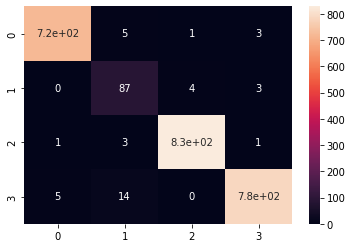

In [44]:
generate_confusion_matrix(y_pred, y_test)

## RandomForestClassifier

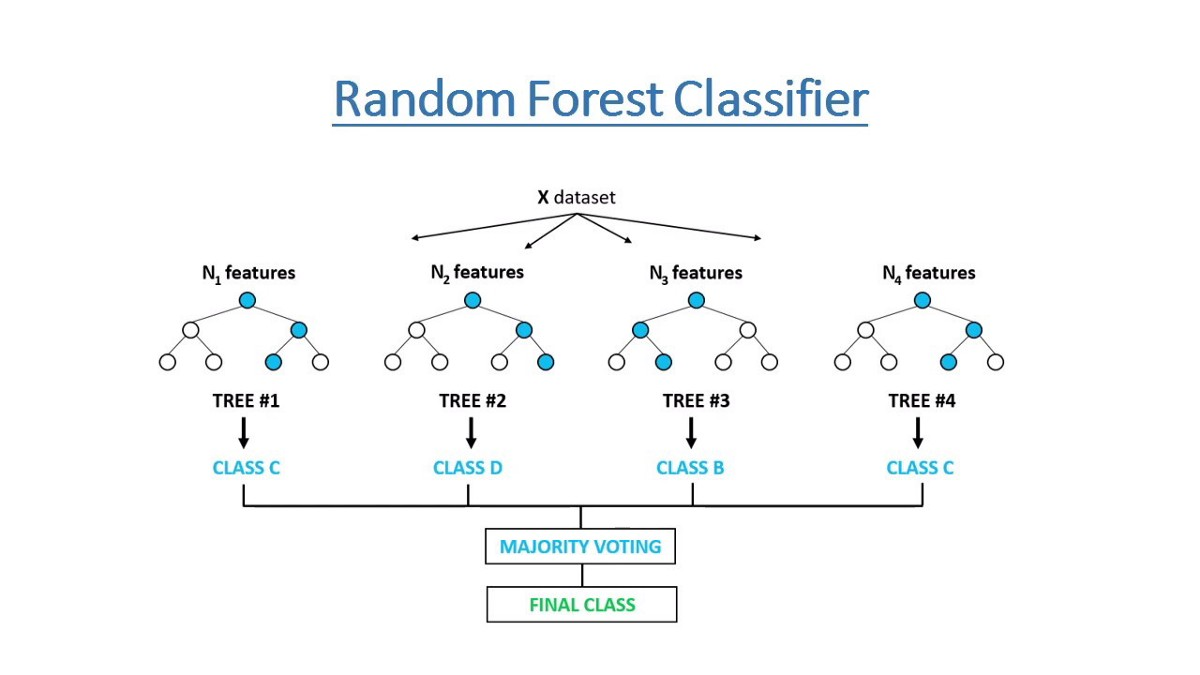

In [45]:
clf = RandomForestClassifier(max_depth=50,n_estimators = 500)
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [46]:
randomforest_acc = accuracy_score(y_pred, y_test)
print(randomforest_acc)

0.9816998779991867


In [47]:
print(classification_report(y_pred, y_test))
#F1 score combines the precision and recall scores of a model. The accuracy metric computes how many times a model made a correct prediction across the entire dataset.

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       729
           1       0.77      0.91      0.84        92
           2       0.99      0.99      0.99       834
           3       0.99      0.97      0.98       804

    accuracy                           0.98      2459
   macro avg       0.94      0.97      0.95      2459
weighted avg       0.98      0.98      0.98      2459



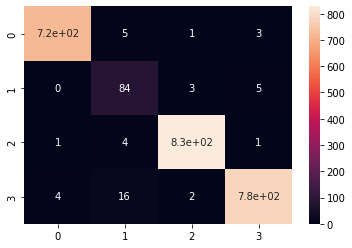

In [48]:
generate_confusion_matrix(y_pred, y_test)

## Support vector machines (SVMs)

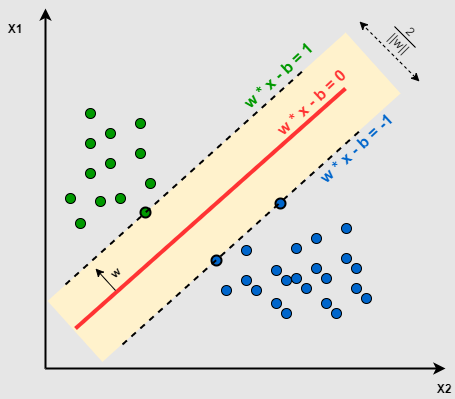

In [49]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(x_tr, np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

In [50]:
svm_acc = accuracy_score(y_pred, y_test)
print(svm_acc)

0.9829198861325742


In [51]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       727
           1       0.79      0.93      0.86        92
           2       0.99      1.00      0.99       832
           3       0.99      0.97      0.98       808

    accuracy                           0.98      2459
   macro avg       0.94      0.97      0.96      2459
weighted avg       0.98      0.98      0.98      2459



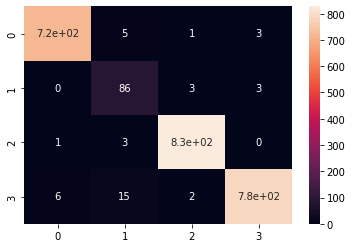

In [52]:
generate_confusion_matrix(y_pred, y_test)

# Final Results

In [53]:
pd.DataFrame({
    "Algorithm": ["DenseNet CNN", "CNN + XGBOOST", "CNN + Random Forest", "CNN + SVM"],
    "Accuracy for same testing data": [cnn_standard_acc, xgboost_acc, randomforest_acc, svm_acc],
}).head()

,Algorithm,Accuracy for same testing data
0,DenseNet CNN,0.985767
1,CNN + XGBOOST,0.983733
2,CNN + Random Forest,0.981700
3,CNN + SVM,0.982920


# Summary
According to the results obtained, neural networks are still able to give better accuracy than the rest of the proposed models.